# Test Set Forecasting Analysis for GARCH(1,1) Model

- Step 1: Obtain parameters simulated from the posterior distribution using the training data

- Step 2: Compute 1-step-ahead forecasts via the Stan generated quantities block using $y_{test}[t-1]$ to predict $y_{test}[t]$ 


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Current working directory: ", os.getcwd())

Current working directory:  c:\Users\nklatsky\econometrics\econometrics2024\project\code\garch


## Read in Real Data

In [3]:
# Read in the train-test split 
# Read train_test.csv
train_test_split = pd.read_csv("../../train_test.csv")
train_size = train_test_split['train'][0]
test_size = train_test_split['test'][0]

# Define data path:
data_path = "../../data/DXY_approx_percent_returns.csv"
real_data = pd.read_csv(data_path, index_col=0)
real_data = real_data - np.mean(real_data)

# calculate the splitting point as the train_size * len of data, rounded
split_point = int(train_size * len(real_data))

# Take test data range only
real_data = real_data.iloc[split_point:]
real_data


,DXY
Date,
2019-08-28,0.214132
2019-08-29,0.301012
2019-08-30,0.413394
2019-02-09,-0.000945
2019-03-09,0.083940
...,...
2024-03-21,-0.411072
2024-03-22,0.567956
2024-03-25,0.448986


# Read in Predictions

In [4]:
# Read in predictions

y_pred_path = "sampler_outputs/y_pred_samples.csv"
y_pred = pd.read_csv(y_pred_path)
y_pred

,0,1,2,3,4,5,6,7,8,9,...,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170
0,0.021509,-0.009388,0.818354,0.868216,0.441313,0.126139,-0.326978,0.537954,-0.057094,-0.455567,...,0.290470,-0.109499,-0.245142,-0.484071,0.005206,0.599952,0.231625,0.444628,0.409481,-0.438969
1,0.071245,-0.305525,-0.489278,0.586627,-0.222824,0.094070,-0.294437,0.144960,-0.509779,1.286690,...,0.324486,0.003908,-0.141020,-0.256271,-0.623802,0.348499,0.013583,0.637342,-0.628199,-1.110920
2,0.268478,0.670317,0.017477,0.011695,0.520073,0.176383,-0.359507,-0.431479,0.133556,0.000275,...,-0.277152,-0.801014,0.256356,0.433740,-0.131579,0.046147,0.264134,0.029790,0.172304,0.046444
3,0.249930,-0.047408,-0.328601,0.473903,0.325168,-0.050168,0.144081,0.390694,0.336539,0.481889,...,0.511260,0.152283,0.027888,-0.491094,0.411944,0.028763,-0.495928,-0.435564,0.503688,0.392437
4,-0.224006,-0.620303,-0.224480,0.506820,0.159498,0.401481,0.693817,-0.029833,-0.038164,0.090677,...,-0.245712,-0.612002,0.234181,0.907548,0.150848,-0.027953,0.360795,-0.012637,0.438122,0.313600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.595221,0.837905,0.394696,-0.493643,-0.061795,-0.222174,-0.318873,-0.601849,0.012603,-0.120877,...,-0.347069,0.407418,-0.662624,-0.253471,1.251690,-1.348050,0.411765,0.159376,-0.450778,-0.276362
3996,0.010364,0.297001,0.378040,-0.485685,0.309002,0.338489,-0.474358,-0.278414,-0.891156,0.718158,...,0.064379,-0.151130,-0.157194,-0.307747,-0.271449,-0.451806,0.374732,0.023910,0.569710,-0.672914
3997,0.743679,-0.316404,0.069526,-0.762448,0.430177,-0.163054,-0.367491,0.306574,0.060177,0.623635,...,0.252525,1.221110,0.087744,-0.505736,-0.413206,0.391114,0.606086,-0.287933,-0.113735,0.112656
3998,-0.089172,-0.090738,0.392680,-0.165016,-0.889118,0.443116,-0.378987,0.086973,-0.378602,0.408322,...,0.192280,-0.304765,0.302758,-0.046218,-0.214526,0.294953,-0.658746,0.350586,-0.032016,0.684983


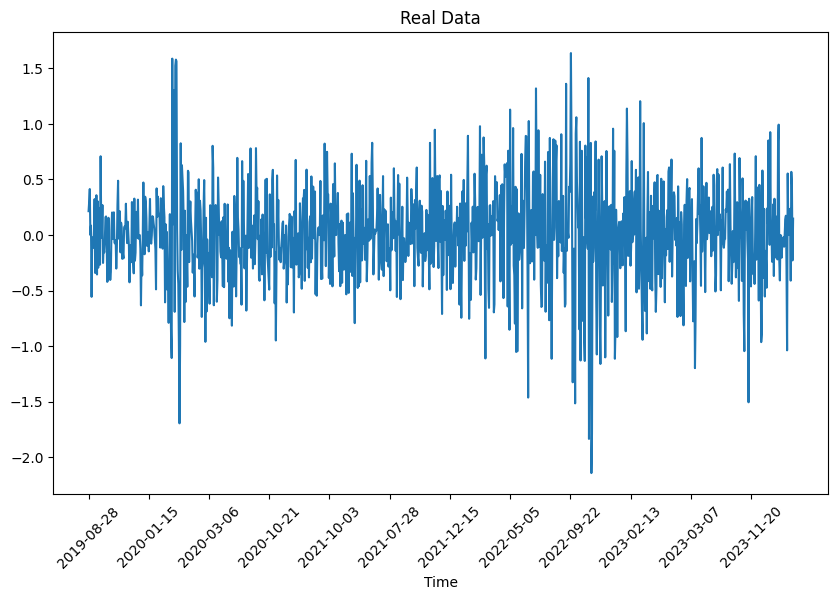

In [10]:
# Plot the real data
plt.figure(figsize=(10, 6))
plt.plot(real_data, label='Real Data')
plt.title('Real Data')
plt.xlabel('Time')
# Reduce tick frequency
plt.xticks(np.arange(0, len(real_data), step=100))
# tilt ticks
plt.xticks(rotation=45)
plt.show()

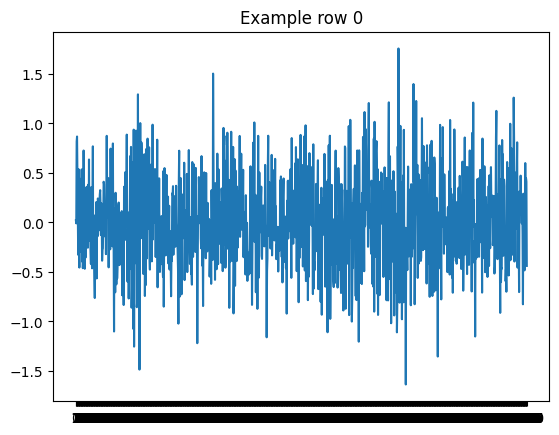

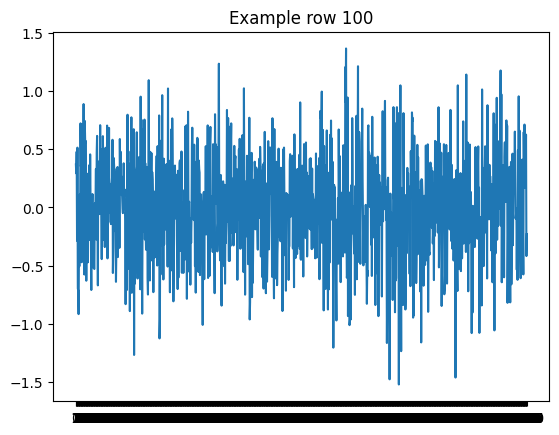

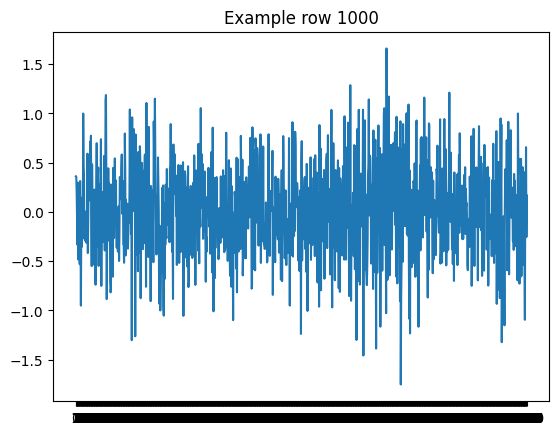

In [6]:
# Plot example rows

idx_list = [0, 100, 1000]
for idx in idx_list:
    plt.plot(y_pred.iloc[idx])
    plt.title(f"Example row {idx}")
    plt.show()

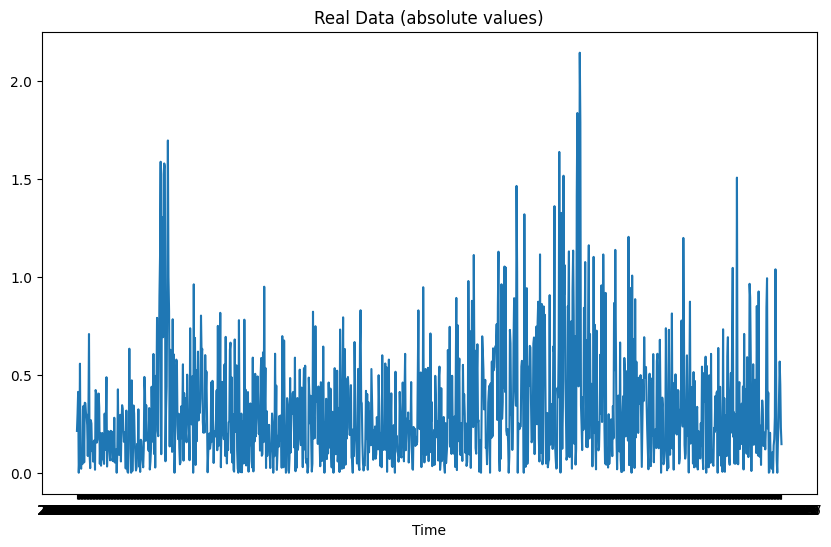

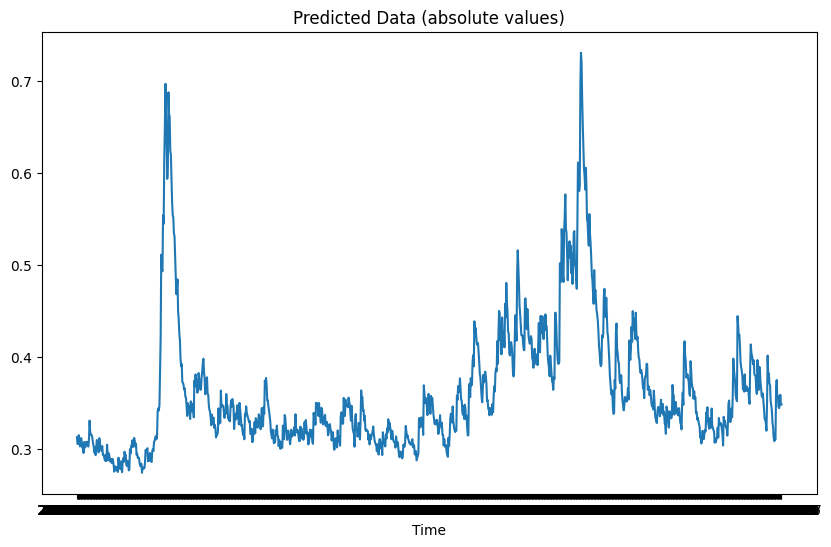

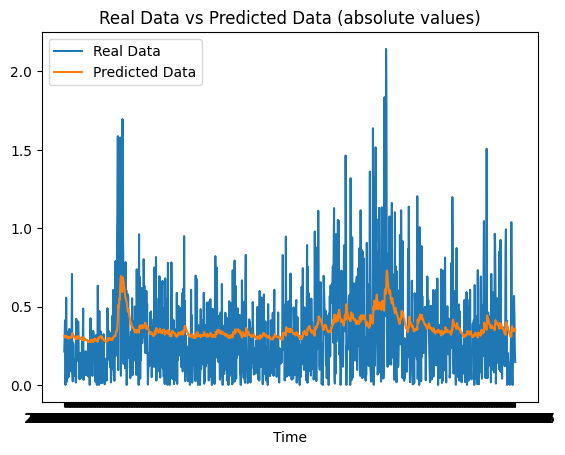

In [12]:
# Take abs of the real data and the predicted data. Then compare the mean over ecah column of the predicted data
real_data_abs = real_data.abs()
y_pred_abs = y_pred.abs()

# Calculate the mean of the absolute values of the predicted data
y_pred_mean = y_pred_abs.mean(axis=0)

# set the index of y_pred_mean to that of real_data_abs
y_pred_mean.index = real_data_abs.index

# Plot the real data
plt.figure(figsize=(10, 6))
plt.plot(real_data_abs, label='Real Data')
plt.title('Real Data (absolute values)')
plt.xlabel('Time')
plt.xticks(np.arange(0, len(real_data), step=100))
plt.xticks(rotation=45)
plt.show()

# Plot the mean of the absolute values of the predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_pred_mean, label='Predicted Data')
plt.title('Predicted Data (absolute values)')
plt.xlabel('Time')
plt.xticks(np.arange(0, len(real_data), step=100))
plt.xticks(rotation=45)
plt.show()


# Plot both series
plt.plot(real_data_abs, label='Real Data')
plt.plot(y_pred_mean, label='Predicted Data')
plt.title('Real Data vs Predicted Data (absolute values)')
plt.xlabel('Time')
plt.xticks(np.arange(0, len(real_data), step=100))
plt.xticks(rotation=45)
plt.legend()
plt.show()

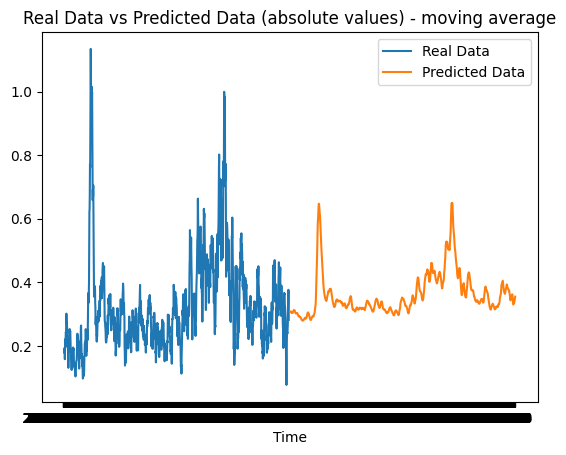

In [8]:
# Plot 5-period moving averages of both series
real_data_abs_ma = real_data_abs.rolling(window=10).mean()
y_pred_mean_ma = y_pred_mean.rolling(window=10).mean()

plt.plot(real_data_abs_ma, label='Real Data')
plt.plot(y_pred_mean_ma, label='Predicted Data')
plt.title('Real Data vs Predicted Data (absolute values) - moving average')
plt.xlabel('Time')
plt.legend()
plt.show()